<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/pymc3_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief introduction to PyMC3

[PyMC3]((https://docs.pymc.io/) is a library that lets the user specify certain kinds of joint probability models using a Python API, that has the "look and feel" similar to the standard way of present hierarchical Bayesian models. Once the (log) joint is defined, it can be used for posterior inference, using either various algorithms, including Hamiltonian Monte Carlo (HMC), and automatic differentiation variational inference (ADVI). More details can be found on the [PyMC3 web page](https://docs.pymc.io/), and in the book [Bayesian Analysis with Python (2nd end)](https://github.com/aloctavodia/BAP) by Osvaldo Martin.

In [1]:
#import pymc3 # colab uses 3.7 by default (as of April 2021)
# arviz needs 3.8+

#!pip install pymc3>=3.8 # fails to update
#!pip install pymc3==3.11 # latest number is hardcoded

!pip install -U pymc3>=3.8

import pymc3 as pm
print(pm.__version__)


3.11.2


In [2]:
#!pip install arviz
import arviz as az
print(az.__version__)

0.11.2


In [3]:
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

## Example: 1d Gaussian with unknown mean.

We use the simple example from the [Pyro intro](https://pyro.ai/examples/intro_part_ii.html#A-Simple-Example). The goal is to infer the weight $\theta$ of an object, given noisy measurements $y$. We assume the following model:
$$
\begin{align}
\theta &\sim N(\mu=8.5, \tau^2=1.0)\\ 
y \sim &N(\theta, \sigma^2=0.75^2)
\end{align}
$$

Where $\mu=8.5$ is the initial guess. 

By Bayes rule for Gaussians, we know that the exact posterior,
given a single observation $y=9.5$, is given by


$$
\begin{align}
\theta|y &\sim N(m, s^s) \\
m &=\frac{\sigma^2 \mu + \tau^2 y}{\sigma^2 + \tau^2} 
  = \frac{0.75^2 \times 8.5 + 1 \times 9.5}{0.75^2 + 1^2}
  = 9.14 \\
s^2 &= \frac{\sigma^2 \tau^2}{\sigma^2  + \tau^2} 
= \frac{0.75^2 \times 1^2}{0.75^2 + 1^2}= 0.6^2
\end{align}
$$

In [4]:
mu = 8.5; tau = 1.0; sigma = 0.75; y = 9.5
m = (sigma**2 * mu + tau**2 * y)/(sigma**2 + tau**2)
s2 = (sigma**2 * tau**2)/(sigma**2 + tau**2)
s = np.sqrt(s2)
print(m)
print(s)

9.14
0.6


In [5]:
# Specify the model

with pm.Model() as model:
  theta = pm.Normal('theta', mu=mu, sd=tau)
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)


#MCMC inference

In [6]:

# run MCMC (defaults to using the NUTS algorithm with 2 chains)
with model:
    trace = pm.sample(1000, random_seed=123)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [7]:
az.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,9.11,0.599,7.944,10.19,0.018,0.013,1108.0,1432.0,1.0


In [ ]:
trace

<MultiTrace: 2 chains, 1000 iterations, 1 variables>

In [ ]:
samples = trace['theta']
print(samples.shape)
post_mean = np.mean(samples)
post_std = np.std(samples)
print([post_mean, post_std])

(2000,)
[9.385980136434414, 0.5790079483638302]


With PyMC3 version >=3.9 the return_inferencedata=True kwarg makes the sample function return an arviz.InferenceData object instead of a MultiTrace.

In [ ]:
with model:
    idata = pm.sample(1000, random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


/usr/local/lib/python3.7/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [ ]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

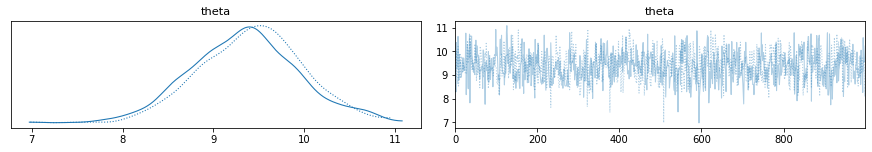

In [ ]:
az.plot_trace(idata);

# Variational inference


We use automatic differentiation VI.
Details can be found at https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [ ]:
niter = 10000
with model:
    post = pm.fit(niter, method='advi'); # mean field approximation

Finished [100%]: Average Loss = 1.1904


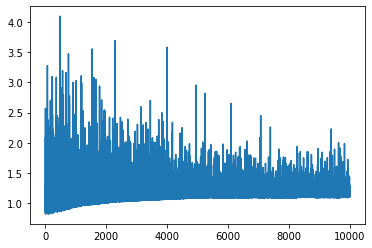

In [ ]:
# Plot negative ELBO vs iteration to assess convergence
plt.plot(post.hist);

In [ ]:
# convert analytic posterior to a bag of iid samples
trace = post.sample(10000)


In [ ]:
samples = trace['theta']
print(samples.shape)
post_mean = np.mean(samples)
post_std = np.std(samples)
print([post_mean, post_std])

(10000,)
[9.387118464165845, 0.6588014467230197]


In [ ]:
az.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,9.387,0.659,8.089,10.579,0.007,0.005,9834.0,9602.0,NaN


# PyMc3 Libraries

There are various libraries that extend pymc3, or use it in various ways, some of which we list below.

- The [arviz](https://github.com/arviz-devs/arviz) library can be used to |visualize (and diagonose problems with) posterior samples drawn from many libraries, including PyMc3.

- The [bambi](https://bambinos.github.io/bambi/) library lets the user specify linear models using "formula syntax", similar to R.

- The [PyMc-learn](https://pymc-learn.readthedocs.io/en/latest/) library offers a sklearn-style API to specify models, but uses PyMc3 under the hood to compute posteriors for model parameters, instead of just point estimates.


